In [ ]:
import numpy as np
import argparse
import dlib
import cv2
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import imutils
from imutils import face_utils
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/mouth_dataset_split.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Shared.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/Shared/shape_predictor_68_face_landmarks.dat')


In [ ]:
def get_data(direc):
    X =[]
    y = []
    IMG_SIZE = 50
    categories = os.listdir(direc)
    for category in categories:
        path_link = os.path.join(direc, category)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image),cv2.IMREAD_GRAYSCALE)
            image_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            X.append(image_array)
            y.append(int(category))
    return X,y



In [ ]:
X_train,y_train = get_data("/content/mouth_dataset_split/train")
X_test,y_test = get_data("/content/mouth_dataset_split/test")

In [ ]:
X_train = np.array(X_train).reshape(-1,50,50,1)
X_test = np.array(X_test).reshape(-1,50,50,1)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [ ]:
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
y_train = y_train.flatten()
y_test = y_test.flatten()

In [ ]:
train_dir = "/content/mouth_dataset_split/train"
test_dir = "/content/mouth_dataset_split/test"

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=2,
                                   zoom_range=0.2,
                                   validation_split=0.2, 
                                   dtype=np.float32)

In [ ]:
batch_train = 2048
batch_val = 512

In [ ]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,  # Source directory
    target_size=(50, 50),  # Resized
    batch_size=batch_val,
    color_mode='grayscale',
    subset='validation',
    class_mode='binary')

Found 807 images belonging to 2 classes.


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Source directory
    target_size=(50, 50),  #Resized to this size
    batch_size=batch_train,
    color_mode='grayscale',
    subset='training',
    class_mode='binary')

Found 3234 images belonging to 2 classes.


In [ ]:
learning_rate = 0.0001
adam = Adam(lr=learning_rate)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor = 'val_loss',
                          min_delta = 0, #minimium amount of change to count as an improvement
                          patience = 10, # how many epochs to wait before stopping
                          verbose = 1,
                          restore_best_weights = True),
    ReduceLROnPlateau(factor=0.9, patience=10, min_lr=0.001),
    ModelCheckpoint('MouthModel.h5', verbose=1, save_best_only=True)#, save_weights_only=True
]

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=X_test.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 128)       

In [ ]:
#history2 = model2.fit(X_train,y_train, batch_size=batch, epochs=100, validation_split=0.2,shuffle = True, verbose=1,callbacks=callbacks)
history2 = model.fit(train_generator, epochs=300, shuffle=True, validation_data=validation_generator, validation_steps=validation_generator.samples//batch_val,steps_per_epoch=train_generator.samples//batch_train, callbacks=callbacks)

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5005
Epoch 1: val_loss improved from inf to 0.68421, saving model to MouthModel.h5
1/1 [==============================] - 5s 5s/step - loss: 0.6934 - accuracy: 0.5005 - val_loss: 0.6842 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.6779 - accuracy: 0.5809
Epoch 2: val_loss improved from 0.68421 to 0.66694, saving model to MouthModel.h5
1/1 [==============================] - 3s 3s/step - loss: 0.6779 - accuracy: 0.5809 - val_loss: 0.6669 - val_accuracy: 0.6992 - lr: 0.0010
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.6992
Epoch 3: val_loss did not improve from 0.66694
1/1 [==============================] - 3s 3s/step - loss: 0.6567 - accuracy: 0.6992 - val_loss: 0.7173 - val_accuracy: 0.5254 - lr: 0.0010
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.7092 - accuracy: 0.4917
Epoc

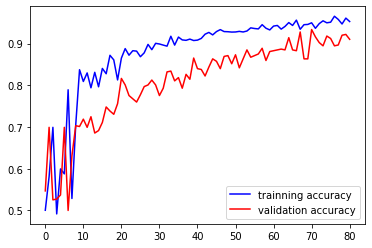

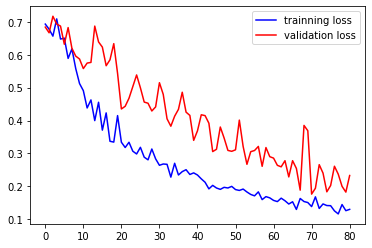

Model Evaluation
Loss: 0.142
Accuracy: 0.943



In [ ]:
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

(loss,acc) = model.evaluate(X_test,y_test, verbose=0)
print('Model Evaluation')
print('Loss: %.3f' % loss)
print('Accuracy: %.3f' % acc)
print()